<a href="https://colab.research.google.com/github/COS-IT-FLOWS/Impacts/blob/main/population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osgeo
!pip install matplotlib
!pip install numpy

  Using cached osgeo-0.0.1.tar.gz (1.2 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for osgeo
  Running setup.py clean for osgeo
Failed to build osgeo
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (osgeo)


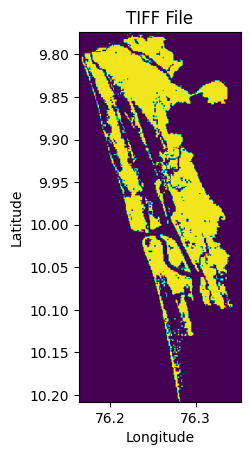

In [ ]:
%matplotlib inline

import osgeo.gdal as gdal
import matplotlib.pyplot as plt

# Specify the path to the TIFF file
filename = '/content/drive/MyDrive/colab files/clip_coastal_population.tif'

# Open the TIFF file using GDAL
gdal_data = gdal.Open(filename)

# Get the first raster band
gdal_band = gdal_data.GetRasterBand(1)

# Convert the TIFF data to a numpy array
data_array = gdal_data.ReadAsArray().astype(float)

# Get the geotransform
geotransform = gdal_data.GetGeoTransform()

# Calculate the x and y coordinates (latitude and longitude)
x_min = geotransform[0]
x_max = x_min + geotransform[1] * data_array.shape[1]
y_min = geotransform[3]
y_max = y_min + geotransform[5] * data_array.shape[0]

# Display the TIFF file using matplotlib with latitude and longitude as axis
plt.imshow(data_array, cmap='viridis', extent=(x_min, x_max, y_min, y_max))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("TIFF File")
plt.show()

In [ ]:
import osgeo.gdal as gdal
import osgeo.ogr as ogr
import numpy as np
import pandas as pd

# Load the DEM raster file
dem_filename = '/content/drive/MyDrive/colab files/clip_coastal_population.tif'
dem_data = gdal.Open(dem_filename)
dem_band = dem_data.GetRasterBand(1)
dem_array = dem_band.ReadAsArray().astype(float)

# Load the shapefile
shapefile_filename = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'
shapefile_data = ogr.Open(shapefile_filename)
layer = shapefile_data.GetLayer()

# Create a list to store the results
results = []

# Iterate over each polygon in the shapefile
for feature in layer:
    geom = feature.GetGeometryRef()

    # Get the bounding box of the polygon
    min_x, max_x, min_y, max_y = geom.GetEnvelope()

    # Calculate the raster indices of the bounding box
    x_off = int((min_x - dem_data.GetGeoTransform()[0]) / dem_data.GetGeoTransform()[1])
    y_off = int((max_y - dem_data.GetGeoTransform()[3]) / dem_data.GetGeoTransform()[5])
    x_size = int((max_x - min_x) / dem_data.GetGeoTransform()[1]) + 1  # +1 to include max_x
    y_size = int((min_y - max_y) / dem_data.GetGeoTransform()[5]) + 1  # +1 to include min_y

    # Extract the DEM values within the bounding box
    dem_values = dem_array[y_off:y_off+y_size, x_off:x_off+x_size]

    # Create a mask for values within the polygon using rasterization
    mask = np.zeros(dem_values.shape, dtype=bool)

    for i in range(dem_values.shape[0]):
        for j in range(dem_values.shape[1]):
            point_x = dem_data.GetGeoTransform()[0] + (x_off + j) * dem_data.GetGeoTransform()[1]
            point_y = dem_data.GetGeoTransform()[3] + (y_off + i) * dem_data.GetGeoTransform()[5]

            # Create a point geometry using ogr.Geometry
            point = ogr.Geometry(ogr.wkbPoint)
            point.AddPoint(point_x, point_y)

            if geom.Contains(point):
                mask[i, j] = True

    # Apply mask to DEM values
    masked_dem_values = np.where(mask, dem_values, np.nan)

    # Calculate the sum of the DEM values within the polygon
    sum_dem_value = np.nansum(masked_dem_values)

    # Get the name of the polygon (replace "NAME" with your actual field name)
    poly_name = feature.GetField("NAME")

    # Append results to list
    results.append({
        # "Index": feature.GetFID(),
        "Polygon Name": poly_name,
        "Population": sum_dem_value
    })

# Create a Pandas DataFrame from results
df = pd.DataFrame(results)

# Print the table
print(df)

       Polygon Name    Population
0             Kochi -3.128544e+07
1       Karumalloor -3.174057e+06
2   Puthenvelikkara -3.616502e+06
3    Chendamangalam -2.481443e+06
4           Paravur -7.729396e+04
5     Chittattukara -5.168251e+05
6       Pallippuram -6.088208e+06
7        Kottuvally -6.341249e+06
8       Kuzhuppilly -4.358865e+06
9        Edavanakad -6.064920e+06
10     Nayarambalam -8.964769e+06
11        Ezhikkara -1.487555e+07
12        Njarackal -5.576386e+06
13   Elamkunnapuzha -6.404148e+06
14       Mulavukadu -1.363351e+07
15      Kadamakkudy -9.780951e+06
16    Cherannalloor -4.063228e+05
17        Varapuzha -4.072809e+06
18     Vadakkekkara -1.664378e+06
19           Maradu -3.764290e+06
20         Kumbalam -1.303868e+07
21        Chellanam -2.107797e+07
22      Kumbalanghy -5.514185e+06


In [ ]:
import osgeo.gdal as gdal
import osgeo.ogr as ogr
import numpy as np
import pandas as pd

# Load the DEM raster file
dem_filename = '/content/drive/MyDrive/colab files/clip_coastal_population.tif'
dem_data = gdal.Open(dem_filename)
dem_band = dem_data.GetRasterBand(1)
dem_array = dem_band.ReadAsArray().astype(float)

# Load the shapefile
shapefile_filename = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'
shapefile_data = ogr.Open(shapefile_filename)
layer = shapefile_data.GetLayer()

# Create a list to store the results
results = []

# Iterate over each polygon in the shapefile
for feature in layer:
    geom = feature.GetGeometryRef()

    # Get the bounding box of the polygon
    min_x, max_x, min_y, max_y = geom.GetEnvelope()

    # Calculate the raster indices of the bounding box
    x_off = int((min_x - dem_data.GetGeoTransform()[0]) / dem_data.GetGeoTransform()[1])
    y_off = int((max_y - dem_data.GetGeoTransform()[3]) / dem_data.GetGeoTransform()[5])
    x_size = int((max_x - min_x) / dem_data.GetGeoTransform()[1]) + 1  # +1 to include max_x
    y_size = int((min_y - max_y) / dem_data.GetGeoTransform()[5]) + 1  # +1 to include min_y

    # Extract the DEM values within the bounding box
    dem_values = dem_array[y_off:y_off+y_size, x_off:x_off+x_size]

    # Create a mask for values within the polygon using rasterization
    mask = np.zeros(dem_values.shape, dtype=bool)

    for i in range(dem_values.shape[0]):
        for j in range(dem_values.shape[1]):
            point_x = dem_data.GetGeoTransform()[0] + (x_off + j) * dem_data.GetGeoTransform()[1]
            point_y = dem_data.GetGeoTransform()[3] + (y_off + i) * dem_data.GetGeoTransform()[5]

            # Create a point geometry using ogr.Geometry
            point = ogr.Geometry(ogr.wkbPoint)
            point.AddPoint(point_x, point_y)

            if geom.Contains(point):
                mask[i, j] = True

    # Apply mask to DEM values
    masked_dem_values = np.where(mask, dem_values, np.nan)

    # Calculate the sum of unique values of pixels within the polygon
    unique_dem_values = np.unique(masked_dem_values[~np.isnan(masked_dem_values)])
    sum_unique_dem_values = np.sum(unique_dem_values)

    # Get the name of the polygon (replace "NAME" with your actual field name)
    poly_name = feature.GetField("NAME")

    # Append results to list
    results.append({
        # "Index": feature.GetFID(),
        "Polygon Name": poly_name,
        "Sum of Unique DEM Values": sum_unique_dem_values
    })

# Create a Pandas DataFrame from results
df = pd.DataFrame(results)

# Add index to the table starting from 1
df.index += 1

# Print the table
print(df)

       Polygon Name  Sum of Unique DEM Values
1             Kochi             632612.642846
2       Karumalloor              25897.962111
3   Puthenvelikkara              13461.513812
4    Chendamangalam               8532.221256
5           Paravur              22675.241116
6     Chittattukara               3169.725764
7       Pallippuram              31695.939949
8        Kottuvally              38654.865515
9       Kuzhuppilly               1092.021746
10       Edavanakad              15019.529966
11     Nayarambalam              15142.043009
12        Ezhikkara               4300.680448
13        Njarackal              13558.234608
14   Elamkunnapuzha              55698.437181
15       Mulavukadu               6355.105408
16      Kadamakkudy               8951.096618
17    Cherannalloor               3606.494894
18        Varapuzha              17150.682728
19     Vadakkekkara               5605.524648
20           Maradu              25672.664749
21         Kumbalam              1

In [ ]:
import osgeo.gdal as gdal
import osgeo.ogr as ogr
import numpy as np
import pandas as pd
from tabulate import tabulate

# Load the DEM raster file
dem_filename = '/content/drive/MyDrive/Lowerbasin/pop_lowerbasin.tif'
dem_data = gdal.Open(dem_filename)
dem_band = dem_data.GetRasterBand(1)
dem_array = dem_band.ReadAsArray().astype(float)

# Load the shapefile
shapefile_filename = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'
shapefile_data = ogr.Open(shapefile_filename)
layer = shapefile_data.GetLayer()

# Create a list to store the results
results = []

# Iterate over each polygon in the shapefile
for feature in layer:
    geom = feature.GetGeometryRef()

    # Get the bounding box of the polygon
    min_x, max_x, min_y, max_y = geom.GetEnvelope()

    # Calculate the raster indices of the bounding box
    x_off = int((min_x - dem_data.GetGeoTransform()[0]) / dem_data.GetGeoTransform()[1])
    y_off = int((max_y - dem_data.GetGeoTransform()[3]) / dem_data.GetGeoTransform()[5])
    x_size = int((max_x - min_x) / dem_data.GetGeoTransform()[1]) + 1  # +1 to include max_x
    y_size = int((min_y - max_y) / dem_data.GetGeoTransform()[5]) + 1  # +1 to include min_y

    # Extract the DEM values within the bounding box
    dem_values = dem_array[y_off:y_off+y_size, x_off:x_off+x_size]

    # Create a mask for values within the polygon using rasterization
    mask = np.zeros(dem_values.shape, dtype=bool)

    for i in range(dem_values.shape[0]):
        for j in range(dem_values.shape[1]):
            point_x = dem_data.GetGeoTransform()[0] + (x_off + j) * dem_data.GetGeoTransform()[1]
            point_y = dem_data.GetGeoTransform()[3] + (y_off + i) * dem_data.GetGeoTransform()[5]

            # Create a point geometry using ogr.Geometry
            point = ogr.Geometry(ogr.wkbPoint)
            point.AddPoint(point_x, point_y)

            if geom.Contains(point):
                mask[i, j] = True

    # Apply mask to DEM values
    masked_dem_values = np.where(mask, dem_values, np.nan)

    # Calculate the sum of unique values of pixels within the polygon
    unique_dem_values = np.unique(masked_dem_values[~np.isnan(masked_dem_values)])
    sum_unique_dem_values = np.sum(unique_dem_values)

    # Get the name of the polygon (replace "NAME" with your actual field name)
    poly_name = feature.GetField("NAME")

    # Append results to list
    results.append({
        # "Index": feature.GetFID(),
        "Polygon Name": poly_name,
        "Sum of Unique DEM Values": sum_unique_dem_values
    })

# Create a Pandas DataFrame from results
df = pd.DataFrame(results)

# Add index to the table starting from 1
df.index += 1

# Print the table
# print(df)
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+-----------------------------------------+----------------------------+
|    | Polygon Name                            |   Sum of Unique DEM Values |
|----+-----------------------------------------+----------------------------|
|  1 | Kochi                                   |                  632145    |
|  2 | Kodassery                               |                   23954.6  |
|  3 | Pariyaram                               |                   14675.8  |
|  4 | Meloor                                  |                   16245.1  |
|  5 | Koratty                                 |                   34312.5  |
|  6 | Aloor                                   |                   40244.1  |
|  7 | Chalakudy                               |                   47471.4  |
|  8 | Kadukutty                               |                    9203.58 |
|  9 | Annamanada                              |                   16436.5  |
| 10 | Kuzhur                                  |                

In [ ]:
# corrected
import osgeo.gdal as gdal
import osgeo.ogr as ogr
import numpy as np
import pandas as pd
from tabulate import tabulate

# Load the DEM raster file
dem_filename = '/content/drive/MyDrive/Lowerbasin/pop_corrected_lower.tif'
dem_data = gdal.Open(dem_filename)
dem_band = dem_data.GetRasterBand(1)
dem_array = dem_band.ReadAsArray().astype(float)

# Load the shapefile
shapefile_filename = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'
shapefile_data = ogr.Open(shapefile_filename)
layer = shapefile_data.GetLayer()

# Create a list to store the results
results = []

# Iterate over each polygon in the shapefile
for feature in layer:
    geom = feature.GetGeometryRef()

    # Get the bounding box of the polygon
    min_x, max_x, min_y, max_y = geom.GetEnvelope()

    # Calculate the raster indices of the bounding box
    x_off = int((min_x - dem_data.GetGeoTransform()[0]) / dem_data.GetGeoTransform()[1])
    y_off = int((max_y - dem_data.GetGeoTransform()[3]) / dem_data.GetGeoTransform()[5])
    x_size = int((max_x - min_x) / dem_data.GetGeoTransform()[1]) + 1  # +1 to include max_x
    y_size = int((min_y - max_y) / dem_data.GetGeoTransform()[5]) + 1  # +1 to include min_y

    # Extract the DEM values within the bounding box
    dem_values = dem_array[y_off:y_off+y_size, x_off:x_off+x_size]

    # Create a mask for values within the polygon using rasterization
    mask = np.zeros(dem_values.shape, dtype=bool)

    for i in range(dem_values.shape[0]):
        for j in range(dem_values.shape[1]):
            point_x = dem_data.GetGeoTransform()[0] + (x_off + j) * dem_data.GetGeoTransform()[1]
            point_y = dem_data.GetGeoTransform()[3] + (y_off + i) * dem_data.GetGeoTransform()[5]

            # Create a point geometry using ogr.Geometry
            point = ogr.Geometry(ogr.wkbPoint)
            point.AddPoint(point_x, point_y)

            if geom.Contains(point):
                mask[i, j] = True

    # Apply mask to DEM values
    masked_dem_values = np.where(mask, dem_values, np.nan)

    # Calculate the sum of unique values of pixels within the polygon
    unique_dem_values = np.unique(masked_dem_values[~np.isnan(masked_dem_values)])
    sum_unique_dem_values = np.sum(unique_dem_values)

    # Get the name of the polygon (replace "NAME" with your actual field name)
    poly_name = feature.GetField("NAME")

    # Append results to list
    results.append({
        # "Index": feature.GetFID(),
        "Polygon Name": poly_name,
        "Sum of Unique DEM Values": sum_unique_dem_values
    })

# Create a Pandas DataFrame from results
df = pd.DataFrame(results)

# Add index to the table starting from 1
df.index += 1

# Print the table
# print(df)
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+-----------------------------------------+----------------------------+
|    | Polygon Name                            |   Sum of Unique DEM Values |
|----+-----------------------------------------+----------------------------|
|  1 | Kochi                                   |                          0 |
|  2 | Kodassery                               |                          0 |
|  3 | Pariyaram                               |                          0 |
|  4 | Meloor                                  |                          0 |
|  5 | Koratty                                 |                          0 |
|  6 | Aloor                                   |                          0 |
|  7 | Chalakudy                               |                          0 |
|  8 | Kadukutty                               |                          0 |
|  9 | Annamanada                              |                          0 |
| 10 | Kuzhur                                  |                

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
adding 2011 census data with 2 % increment and plotting it

In [ ]:
import osgeo.ogr as ogr
import pandas as pd

# Load the shapefile
# Update with the actual path to your shapefile
shapefile_path = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'
shapefile_data = ogr.Open(shapefile_path)

# Check if the shapefile was opened successfully
if shapefile_data is None:
    print(f"Error: Could not open shapefile at '{shapefile_path}'")
    # Handle the error (e.g., exit the script, raise an exception)
else:
    layer = shapefile_data.GetLayer()

# Get the field names from the shapefile
layer_defn = layer.GetLayerDefn()
field_names = [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())]
print("Available field names:", field_names)  # Print available field names

# Create a list to store the results
results = []

# Iterate over each polygon in the shapefile
for feature in layer:
    geom = feature.GetGeometryRef()

    # Replace 'your_actual_field_name' with the correct field name from the printed list
    panchayat_name = feature.GetField("NAME")  # Replace with your actual field name if exists in the field_names
    # If the field does not exist or data not present, you can set to default value

    # Calculate the area of the polygon in square kilometers
    area_km2 = geom.Area() * 10000

    # Append results to list
    results.append({
        "Index": len(results) + 1,
        "Panchayat Name": panchayat_name,
        "Area (km²)": area_km2
    })

# Create a Pandas DataFrame from results
df = pd.DataFrame(results)

# Print the table
print(df)

Available field names: ['@id', 'admin_leve', 'boundary', 'local_auth', 'name', 'type', 'wikidata', 'FID', 'population', 'Block name', 'Extent', 'Flood_type']
    Index   Panchayat Name  Area (km²)
0       1            Kochi   82.576207
1       2      Karumalloor   15.991899
2       3  Puthenvelikkara   14.945859
3       4   Chendamangalam    9.278022
4       5          Paravur    7.367666
5       6    Chittattukara    5.707700
6       7      Pallippuram   11.771126
7       8       Kottuvally   18.547844
8       9      Kuzhuppilly    5.291411
9      10       Edavanakad    8.545664
10     11     Nayarambalam   10.080030
11     12        Ezhikkara   14.696299
12     13        Njarackal    7.431756
13     14   Elamkunnapuzha   15.149081
14     15       Mulavukadu   12.692222
15     16      Kadamakkudy   13.204945
16     17    Cherannalloor    3.492637
17     18        Varapuzha    8.628890
18     19     Vadakkekkara    8.133250
19     20           Maradu    9.936647
20     21         Kumba

In [ ]:
import osgeo.ogr as ogr
import pandas as pd

# Load the shapefile
# Update with the actual path to your shapefile
shapefile_path = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'
shapefile_data = ogr.Open(shapefile_path)

# Check if the shapefile was opened successfully
if shapefile_data is None:
    print(f"Error: Could not open shapefile at '{shapefile_path}'")
    # Handle the error (e.g., exit the script, raise an exception)
else:
    layer = shapefile_data.GetLayer()

# Get the field names from the shapefile
layer_defn = layer.GetLayerDefn()
field_names = [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())]
print("Available field names:", field_names)  # Print available field names

# Create a list to store the results
results = []

# Iterate over each polygon in the shapefile
for feature in layer:
    geom = feature.GetGeometryRef()

    # Replace 'your_actual_field_name' with the correct field name from the printed list
    panchayat_name = feature.GetField("NAME")  # Replace with your actual field name if exists in the field_names
    # If the field does not exist or data not present, you can set to default value

    # Calculate the area of the polygon in square kilometers
    area_km2 = geom.Area() * 10000

    # Append results to list
    results.append({
        "Index": len(results) + 1,
        "Panchayat Name": panchayat_name,
        "Area (km²)": area_km2
    })

# Create a Pandas DataFrame from results
df = pd.DataFrame(results)

# Print the table
print(df)

Available field names: ['id', '@id', '@relations', 'admin_leve', 'boundary', 'local_auth', 'name', 'name_kn', 'name_ml', 'name_ta', 'ns', 'population', 'type', 'wikidata', 'wikipedia']
    Index                Panchayat Name  Area (km²)
0       1                         Kochi   82.576207
1       2                     Kodassery   40.811027
2       3                     Pariyaram   24.525529
3       4                        Meloor   18.264371
4       5                       Koratty   20.221185
..    ...                           ...         ...
69     70                         Eloor   10.775254
70     71  Choornikkara Gramapanchayath    6.887735
71     72                   Kalamassery   31.279474
72     73      Edathala Gramapanchayath   16.168143
73     74                        Maradu    9.936647

[74 rows x 3 columns]


In [ ]:
import osgeo.ogr as ogr
import osgeo.osr as osr
import pandas as pd

# Load the shapefile
shapefile_path = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'
shapefile_data = ogr.Open(shapefile_path)

# Check if the shapefile was opened successfully
if shapefile_data is None:
    print(f"Error: Could not open shapefile at '{shapefile_path}'")
else:
    layer = shapefile_data.GetLayer()

# Get the field names from the shapefile
layer_defn = layer.GetLayerDefn()
field_names = [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())]
print("Available field names:", field_names)

# Create a list to store the results
results = []

# Define the target spatial reference (EPSG:32643)
target_srs = osr.SpatialReference()
target_srs.ImportFromEPSG(32643)

# Create a coordinate transformation
source_srs = layer.GetSpatialRef()  # Get the source spatial reference
transform = osr.CoordinateTransformation(source_srs, target_srs)

# Iterate over each polygon in the shapefile
for feature in layer:
    geom = feature.GetGeometryRef()

    # Reproject the geometry to EPSG:32643
    geom.Transform(transform)

    # Replace 'NAME' with the correct field name from the printed list
    panchayat_name = feature.GetField("NAME")  # Adjust if necessary

    # Calculate the area of the polygon in square kilometers
    area_km2 = geom.Area() * 0.0001  # Area in square meters converted to square kilometers

    # Append results to list
    results.append({
        "Index": len(results) + 1,
        "Panchayat Name": panchayat_name,
        "Area (km²)": area_km2
    })

# Create a Pandas DataFrame from results
df = pd.DataFrame(results)

# Print the table
print(df)

Available field names: ['id', '@id', '@relations', 'admin_leve', 'boundary', 'local_auth', 'name', 'name_kn', 'name_ml', 'name_ta', 'ns', 'population', 'type', 'wikidata', 'wikipedia']
    Index                Panchayat Name    Area (km²)
0       1                         Kochi  10011.851241
1       2                     Kodassery   4942.872501
2       3                     Pariyaram   2970.728387
3       4                        Meloor   2212.396482
4       5                       Koratty   2449.632919
..    ...                           ...           ...
69     70                         Eloor   1306.040891
70     71  Choornikkara Gramapanchayath    834.842813
71     72                   Kalamassery   3791.825517
72     73      Edathala Gramapanchayath   1959.842610
73     74                        Maradu   1204.913533

[74 rows x 3 columns]


In [ ]:
import geopandas as gpd
import pandas as pd

def compare_and_add_population(shapefile_path, csv_path):
    # Load the panchayat boundary shapefile
    panchayat_shapefile = gpd.read_file(shapefile_path)

    # Load the CSV file containing panchayat names and population
    population_data = pd.read_csv(csv_path)

    # Print the list of panchayat names in both inputs
    shapefile_names = panchayat_shapefile['name'].unique()  # Adjust 'name' to the actual column name in the shapefile
    csv_names = population_data['name'].unique()  # Adjust 'panchayat_name' to the actual column name in the CSV

    print("Panchayat names in Shapefile:")
    print(shapefile_names)

    print("\nPanchayat names in CSV:")
    print(csv_names)

    # Find matching panchayat names
    matching_names = set(shapefile_names) & set(csv_names)
    print("\nMatching Panchayat Names:")
    print(matching_names)
    len(matching_names)

    # Merge the population data into the shapefile based on matching names
    merged_data = panchayat_shapefile.merge(population_data, left_on='name', right_on='name', how='left')

    # Save the updated shapefile with the new population column
    updated_shapefile_path = '/content/drive/MyDrive/Lowerbasin/updated_popupanchayat_shapefile.shp'
    merged_data.to_file(updated_shapefile_path, driver='ESRI Shapefile')

    print(f"\nUpdated shapefile saved to: {updated_shapefile_path}")

# Example usage
shapefile_path = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'  # Adjust the path as necessary
csv_path = '/content/drive/MyDrive/Lowerbasin/kl_ppp_lsg_editted.csv'  # Adjust the path as necessary

compare_and_add_population(shapefile_path, csv_path)

Panchayat names in Shapefile:
['Kochi' 'Kodassery' 'Pariyaram' 'Meloor' 'Koratty' 'Aloor' 'Chalakudy'
 'Kadukutty' 'Annamanada' 'Kuzhur' 'Mala' 'Poyya' 'Kodungallur' 'Eriyad'
 'Edavilangu' 'Sree Narayanapuram' 'Mathilakam' 'Perinjanam' 'Padiyoor'
 'Vellangalur' 'Puthenchira' 'Velookkara' 'Poomangalam'
 'Ayyampuzha Gramapanchayath' 'Kottappady Grama Panchayath'
 'Vengoor Gramapanchayath' 'Koovappady Gramapanchayath'
 'Mudakkuzha Gramapanchayath' 'Malayattoor-Neeleswaram Gramapanchayath'
 'Kalady Gramapanchayath' 'Manjapra Gramapanchayath'
 'Thuravoor Gramapanchayat' 'Mookkannoor Gramapanchayath'
 'Karukutty Gramapanchayath' 'Parakkadavu Gramapanchayath' 'Angamaly'
 'Nedumbassery Gramapanchayath' 'Sreemoolanagaram Gramapanchayath'
 'Chengamanadu Gramapanchayath' 'Okkal Gramapanchayath' 'Perumbavoor'
 'Rayamangalam Gramapanchayath' 'Asamannur Gramapanchayath'
 'Vengola Gramapanchayath' 'Vazhakkulam Gramapanchayath'
 'Kanjoor Gramapanchayath' 'Keezhmadu Gramapanchayath' 'Aluva'
 'Kunnukara

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.4 MB/s eta 0:00:00


In [42]:
import rasterio
import rasterio.features
import geopandas as gpd
import numpy as np
import pandas as pd
from tabulate import tabulate

# Load the population count TIFF
with rasterio.open(r"/content/drive/MyDrive/Lowerbasin/unadj_bounding.tif") as src:
    count_array = src.read(1)  # Read the first band (assuming it's the population count)
    no_data_value = src.nodata  # Get the no-data value from the raster
    raster_crs = src.crs  # Get the CRS of the raster

# Load the boundary shapefile
boundary = gpd.read_file(r"/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp")

# Ensure the boundary is in the same CRS as the raster
boundary = boundary.to_crs(raster_crs)

# Print the CRS of the boundary
print("Boundary CRS:", boundary.crs)

# Print the CRS of the raster
print("Raster CRS:", raster_crs)

# Initialize a list to store results
results = []
total_population_sum = 0  # Initialize total population sum

# Iterate through each polygon in the boundary
for index, row in boundary.iterrows():
    geom = row.geometry

    # Create a mask for the current polygon
    mask = rasterio.features.rasterize(
        [(geom, 1)],
        out_shape=count_array.shape,
        transform=src.transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )

    # Apply the mask to the count array
    clipped_array = np.where(mask, count_array, np.nan)

    # Exclude no-data values from the sum
    total_population = np.nansum(clipped_array[clipped_array != no_data_value])

    # Round the total population to zero decimal places
    total_population_rounded = round(total_population)

    # Append the results to the list
    results.append({'Polygon_Name': row['name'], 'Population': total_population_rounded})  # Replace 'name' with the actual column name for polygon names

    # Add to the total population sum
    total_population_sum += total_population_rounded

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(tabulate(results_df, headers='keys', tablefmt='psql'))

# Print the total population across all polygons
print(f"\nTotal Population Count Across All Polygons: {total_population_sum}")

# Optionally, save the DataFrame to a CSV file
# results_df.to_csv(r"C:\Users\Dell\Desktop\Ezhikkara\Lowerbasin\population_by_polygon.csv", index=False)

Boundary CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Raster CRS: EPSG:4326
+----+-----------------------------------------+--------------+
|    | Polygon_Name                            |   Population |
|----+-----------------------------------------+--------------|
|  0 | Kochi                                   |       629488 |
|  1 | Kodassery                               |        24538 |
|  2 | Pariyaram                               |        31658 |
|  3 | Meloor                                  |        27432 |
|  4 | Koratty                                 |        43426 |
|  5 | Aloor                                   |        62543 |
|  6 | Chalakudy                               |        60719 |
|  7 | Kadukutty     

In [47]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import pandas as pd
from tabulate import tabulate
import os

def clip_raster_and_count_population(thresholds, elevation_shp_path_template, boundary_shp_path, raster_path, output_dir):
    # Load the boundary shapefile
    boundary = gpd.read_file(boundary_shp_path)

    # Initialize a list to store results
    results = []

    for threshold in thresholds:
        # Create the elevation shapefile path using the current threshold
        elevation_shp_path = elevation_shp_path_template.format(threshold=threshold)

        # Load the elevation shapefile for the current threshold
        elevation_shp = gpd.read_file(elevation_shp_path)

        # Ensure the boundary is in the same CRS as the elevation shapefile
        boundary = boundary.to_crs(elevation_shp.crs)

        # Clip the population raster using the elevation shapefile
        with rasterio.open(raster_path) as src:
            # Mask the raster with the elevation polygons
            clipped_raster, clipped_transform = rasterio.mask.mask(src, elevation_shp.geometry, crop=True, nodata=src.nodata)
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                "driver": "GTiff",
                "height": clipped_raster.shape[1],
                "width": clipped_raster.shape[2],
                "transform": clipped_transform
            })

            # Save the clipped raster to the specified output directory
            clipped_raster_path = os.path.join(output_dir, f"clipped_population_{threshold}.tif")
            with rasterio.open(clipped_raster_path, "w", **clipped_meta) as dest:
                dest.write(clipped_raster)

        # Count population within each polygon in the boundary shapefile
        with rasterio.open(clipped_raster_path) as clipped_src:
            count_array = clipped_src.read(1)  # Read the clipped population data
            no_data_value = clipped_src.nodata  # Get the no-data value from the clipped raster

            # Iterate through each polygon in the boundary
            for index, row in boundary.iterrows():
                geom = row.geometry

                # Create a mask for the current polygon
                mask = rasterio.features.rasterize(
                    [(geom, 1)],
                    out_shape=count_array.shape,
                    transform=clipped_src.transform,
                    fill=0,
                    all_touched=True,
                    dtype='uint8'
                )

                # Apply the mask to the count array
                masked_array = np.where(mask, count_array, np.nan)

                # Exclude no-data values from the sum
                total_population = np.nansum(masked_array[masked_array != no_data_value])

                # Round the total population to zero decimal places
                total_population_rounded = round(total_population)
                # Accumulate the total population for this threshold
                # total_population_sum += total_population_rounded

                # Append the results to the list
                results.append({
                    'Polygon_Name': row['name'],
                    'Total_Population': total_population_rounded,
                    'Threshold': threshold
                })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(tabulate(results_df, headers='keys', tablefmt='psql'))
    # print(f"\nTotal Population Count Across All Polygons: {total_population_rounded}")
    # Save the DataFrame to a CSV file in the specified output directory
    # results_df.to_csv(os.path.join(output_dir, "population_by_polygon.csv"), index=False)

# Example usage
thresholds = [3.0]  # Define your thresholds
elevation_shp_path_template = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"  # Template for elevation shapefile paths
boundary_shp_path = "/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp"  # Path to boundary shapefile
raster_path = "/content/drive/MyDrive/Lowerbasin/unadj_bounding.tif"  # Path to the raster file
output_dir = "/content/drive/MyDrive/Lowerbasin/clipped_pop"  # Directory to save output files

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Run the function
clip_raster_and_count_population(thresholds, elevation_shp_path_template, boundary_shp_path, raster_path, output_dir)


+----+-----------------------------------------+--------------------+-------------+
|    | Polygon_Name                            |   Total_Population |   Threshold |
|----+-----------------------------------------+--------------------+-------------|
|  0 | Kochi                                   |             428571 |           3 |
|  1 | Kodassery                               |                 57 |           3 |
|  2 | Pariyaram                               |                 94 |           3 |
|  3 | Meloor                                  |                776 |           3 |
|  4 | Koratty                                 |                 32 |           3 |
|  5 | Aloor                                   |                561 |           3 |
|  6 | Chalakudy                               |                995 |           3 |
|  7 | Kadukutty                               |                471 |           3 |
|  8 | Annamanada                              |               2983 |       

In [48]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import pandas as pd
from tabulate import tabulate
import os

def clip_raster_and_count_population(thresholds, elevation_shp_path_template, boundary_shp_path, raster_path, output_dir):
    # Load the boundary shapefile
    boundary = gpd.read_file(boundary_shp_path)

    # Initialize a list to store results
    results = []

    for threshold in thresholds:
        # Create the elevation shapefile path using the current threshold
        elevation_shp_path = elevation_shp_path_template.format(threshold=threshold)

        # Load the elevation shapefile for the current threshold
        elevation_shp = gpd.read_file(elevation_shp_path)

        # Ensure the boundary is in the same CRS as the elevation shapefile
        boundary = boundary.to_crs(elevation_shp.crs)

        # Clip the population raster using the elevation shapefile
        with rasterio.open(raster_path) as src:
            # Mask the raster with the elevation polygons
            clipped_raster, clipped_transform = rasterio.mask.mask(src, elevation_shp.geometry, crop=True, nodata=src.nodata)
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                "driver": "GTiff",
                "height": clipped_raster.shape[1],
                "width": clipped_raster.shape[2],
                "transform": clipped_transform
            })

            # Save the clipped raster to the specified output directory
            clipped_raster_path = os.path.join(output_dir, f"clipped_population_{threshold}.tif")
            with rasterio.open(clipped_raster_path, "w", **clipped_meta) as dest:
                dest.write(clipped_raster)

        # Count population within each polygon in the boundary shapefile
        with rasterio.open(clipped_raster_path) as clipped_src:
            count_array = clipped_src.read(1)  # Read the clipped population data
            no_data_value = clipped_src.nodata  # Get the no-data value from the clipped raster

            # Initialize total population sum for this threshold
            total_population_sum = 0

            # Iterate through each polygon in the boundary
            for index, row in boundary.iterrows():
                geom = row.geometry

                # Create a mask for the current polygon
                mask = rasterio.features.rasterize(
                    [(geom, 1)],
                    out_shape=count_array.shape,
                    transform=clipped_src.transform,
                    fill=0,
                    all_touched=True,
                    dtype='uint8'
                )

                # Apply the mask to the count array
                masked_array = np.where(mask, count_array, np.nan)

                # Exclude no-data values from the sum
                total_population = np.nansum(masked_array[masked_array != no_data_value])

                # Round the total population to zero decimal places
                total_population_rounded = round(total_population)

                # Append the results to the list
                results.append({
                    'Polygon_Name': row['name'],
                    'Total_Population': total_population_rounded,
                    'Threshold': threshold
                })

                # Accumulate the total population for this threshold
                total_population_sum += total_population_rounded

            # Print the total population for this threshold
            print(f"\nTotal Population Count Across All Polygons for Threshold {threshold}: {total_population_sum}")

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(tabulate(results_df, headers='keys', tablefmt='psql'))

    # Save the DataFrame to a CSV file in the specified output directory
    results_df.to_csv(os.path.join(output_dir, "population_by_polygon.csv"), index=False)

# Example usage
thresholds = [12.48]  # Define your thresholds
elevation_shp_path_template = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"  # Template for elevation shapefile paths
boundary_shp_path = "/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp"  # Path to boundary shapefile
raster_path = "/content/drive/MyDrive/Lowerbasin/unadj_bounding.tif"  # Path to the raster file
output_dir = "/content/drive/MyDrive/Lowerbasin/clipped_pop"  # Directory to save output files

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Run the function
clip_raster_and_count_population(thresholds, elevation_shp_path_template, boundary_shp_path, raster_path, output_dir)


Total Population Count Across All Polygons for Threshold 12.48: 2371586
+----+-----------------------------------------+--------------------+-------------+
|    | Polygon_Name                            |   Total_Population |   Threshold |
|----+-----------------------------------------+--------------------+-------------|
|  0 | Kochi                                   |             621960 |       12.48 |
|  1 | Kodassery                               |               1630 |       12.48 |
|  2 | Pariyaram                               |               8053 |       12.48 |
|  3 | Meloor                                  |              13350 |       12.48 |
|  4 | Koratty                                 |              11146 |       12.48 |
|  5 | Aloor                                   |              19044 |       12.48 |
|  6 | Chalakudy                               |              36399 |       12.48 |
|  7 | Kadukutty                               |              21415 |       12.48 |
|  

<ipython-input-30-ba5ffbfd7521>:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


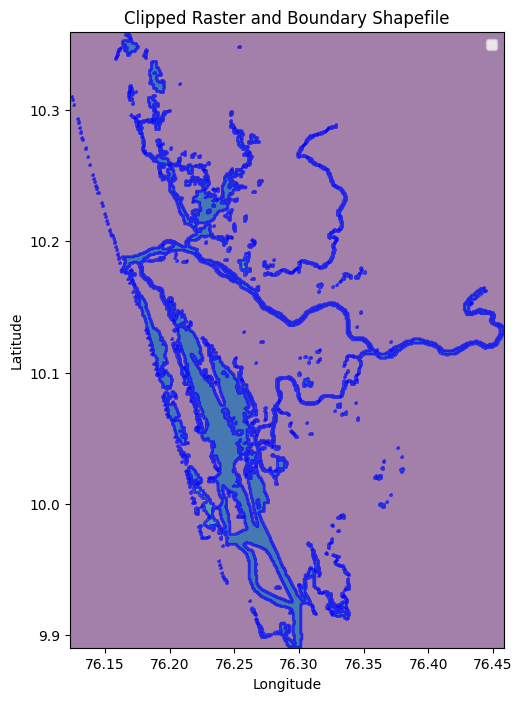

In [30]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt

def load_and_display(clipped_raster_path, boundary_shp_path):
    # Load the clipped raster
    with rasterio.open(clipped_raster_path) as src:
        clipped_raster = src.read(1)  # Read the first band
        raster_transform = src.transform  # Get the transform for the raster

    # Load the boundary shapefile
    boundary = gpd.read_file(boundary_shp_path)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the clipped raster
    rasterio.plot.show(clipped_raster, transform=raster_transform, ax=ax, cmap='viridis', alpha=0.5)

    # Plot the boundary shapefile
    boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='Boundary', alpha=0.7)

    # Set the title and labels
    ax.set_title("Clipped Raster and Boundary Shapefile")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Set the background color to transparent
    ax.set_facecolor('none')  # Set the axis background to transparent

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

# Example usage
clipped_raster_path = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/clipped_population_1.0.tif"  # Path to the clipped raster
boundary_shp_path = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/1.0poly_lower.shp"  # Path to the boundary shapefile

# Call the function to load and display
load_and_display(clipped_raster_path, boundary_shp_path)